<a href="https://colab.research.google.com/github/prime89-hash/DevOpsClassCodes/blob/master/Titanic_Workshop_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic ML Hack Event

## 🛳️ Titanic Dataset

This project uses the [Titanic Dataset](https://www.kaggle.com/datasets/yasserh/titanic-dataset?resource=download), a classic dataset from Kaggle often used for machine learning and data analysis tutorials.

### 📋 Dataset Description

The dataset provides information about passengers aboard the Titanic, including demographic details and survival outcomes from the 1912 disaster.

**Columns:**

| Column Name | Description |
|--------------|-------------|
| **PassengerId** | Unique identifier for each passenger |
| **Survived** | Survival indicator (0 = No, 1 = Yes) |
| **Pclass** | Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd) |
| **Name** | Full name of the passenger |
| **Sex** | Gender of the passenger |
| **Age** | Age in years |
| **SibSp** | Number of siblings/spouses aboard |
| **Parch** | Number of parents/children aboard |
| **Ticket** | Ticket number |
| **Fare** | Passenger fare |
| **Cabin** | Cabin number (may contain missing values) |
| **Embarked** | Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) |

### 📊 Notes

- The dataset contains **891 rows** and **12 columns**.
- Some fields such as **Age**, **Cabin**, and **Embarked** contain missing values.
- This dataset is widely used for binary classification tasks (predicting survival).


## 🚀 Download the Dataset and Install the Dependencies

Run the following cells once.

In [5]:
#Download the Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/titanic-dataset")

print("Path to dataset files:", path)

100%|██████████| 22.0k/22.0k [00:00<00:00, 14.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/yasserh/titanic-dataset/versions/1


In [6]:
#Upgrade Dependencies
import pkg_resources
import shap
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix


required = {
    "shap": "0.50.0",
    "xgboost": "3.1.1"
}

installed = {
    "shap": shap.__version__,
    "xgboost": xgboost.__version__
}

for pkg in required:
    if pkg_resources.parse_version(installed[pkg]) < pkg_resources.parse_version(required[pkg]):
        !pip install -U {pkg}
    else:
        print(f"{pkg} is up to date.")

print("shap version:", shap.__version__)
print("xgboost version:", xgboost.__version__)


/tmp/ipython-input-1241851065.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


shap is up to date.
xgboost is up to date.
shap version: 0.50.0
xgboost version: 3.1.3


# **1. 📊 Data Exploration**
---


## 🧭 Preparing Model Input Fields (Features)

Before training our XGBoost model, we perform some light feature preparation:

### 1) Remove irrelevant fields
- Drop fields that do not help predict the target  
  e.g., IDs, free-text identifiers, or columns with no predictive value.

### 2) Ensure fields have correct data types
- Numerical fields should be numeric  
- Categorical fields should be cast to `category` for native XGBoost handling

### 3) Decide how to handle missing values
- Identify where nulls occur
- Choose a simple approach (e.g., median for Age)

### 4) Apply ranges / bins where useful
- Group continuous fields into meaningful buckets  
  e.g., Age groups, Fare ranges

### 5) Create new engineered fields
- Extract useful information from existing data  
  e.g., Title derived from Name, FamilySize, IsAlone


In [7]:
import pandas as pd

# Load the CSV file
original_df = pd.read_csv('/kaggle/input/titanic-dataset/Titanic-Dataset.csv')
print(original_df.dtypes)
original_df.head(5)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# **2. 🔧 Featurization**
---



In [22]:
# Create a working copy
featurization_df = original_df.copy()
#Drop PassengerId, it's an index value which isn't relevant to the prediction
featurization_df.drop(columns=["PassengerId"], inplace=True)

## 🔍 Featurization: *Age*
### Fill the null values

In [24]:
featurization_df["Age"] = featurization_df["Age"].fillna(featurization_df["Age"].median())


## 🔍 Featurization: *Title*
What can we extract from the name e.g. "Byles, Rev. Thomas Roussel Davids"

In [10]:
featurization_df['Title'] = featurization_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

## 🔍 Featurization: *Fare*
Can we cluster the fare paid into ranges? How many buckets would work?

In [11]:
featurization_df["fareBucket"] = pd.qcut(featurization_df['Fare'], 3, labels=['Low', 'Medium', 'High'])

## 🔍 Featurization: *Family Size*
Does family size matter?

In [27]:
featurization_df["FamilySize"] = featurization_df['SibSp'] + featurization_df['Parch']
print(featurization_df)

     Survived  Pclass                                               Name  \
0           0       3                            Braund, Mr. Owen Harris   
1           1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2           1       3                             Heikkinen, Miss. Laina   
3           1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4           0       3                           Allen, Mr. William Henry   
..        ...     ...                                                ...   
886         0       2                              Montvila, Rev. Juozas   
887         1       1                       Graham, Miss. Margaret Edith   
888         0       3           Johnston, Miss. Catherine Helen "Carrie"   
889         1       1                              Behr, Mr. Karl Howell   
890         0       3                                Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  \
0      mal

## 🔍 Featurization: *Others*

In [25]:
import numpy as np

featurization_df["IsAlone"] = np.where(featurization_df["FamilySize"] == 0, 1, 0)

featurization_df["CabinDeck"] = featurization_df["Cabin"].str[0]

#featurization_df["Pclass"] = ?
#featurization_df["Sex"] = ?
#featurization_df["SibSp"] = ?
#featurization_df["Parch"] = ?
#featurization_df["Ticket"] = ?
#featurization_df["Cabin"] = ?
#featurization_df["Embarked"] = ?

KeyError: 'FamilySize'

## 🔍 Featurization: TYPES - **remeber to add new category fields here**
Check that the fields have the correct data types

In [14]:
# Cast categoricals for XGBoost native categorical handling
for cat_col in [c for c in ["Sex", "Embarked", "Title", "fareBucket", "IsAlone", "CabinDeck"] if c in featurization_df.columns]:
    featurization_df[cat_col] = featurization_df[cat_col].astype("category")

featurization_df["Survived"] = featurization_df["Survived"].astype(int)
print(featurization_df.dtypes)

Survived         int64
Pclass           int64
Name            object
Sex           category
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked      category
Title         category
fareBucket    category
FamilySize       int64
IsAlone       category
CabinDeck     category
dtype: object


## Select the fields to use in model
Create a working copy to send into the training stage

In [15]:
# Create a working copy
#ORIGINAL FIELDS - PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
train_test_df = featurization_df[['Age', 'Fare', 'Survived', 'Title', 'FamilySize', 'fareBucket', 'IsAlone', 'CabinDeck']].copy()

# **3. 🧪 Training / Test Data Preparation**
---

In [16]:
# 3-way split: 70% train, 15% valid, 15% test
from sklearn.model_selection import train_test_split

target_col = "Survived"
X = train_test_df.drop(columns=[target_col])
y = train_test_df[target_col]

# First: train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second: split temp into valid vs test (50/50 of 30% -> 15% each)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)
print("Class balance train:", y_train.value_counts(normalize=True).to_dict())
print("Class balance valid:", y_valid.value_counts(normalize=True).to_dict())
print("Class balance test :", y_test.value_counts(normalize=True).to_dict())

Train: (623, 7) Valid: (134, 7) Test: (134, 7)
Class balance train: {0: 0.6163723916532905, 1: 0.38362760834670945}
Class balance valid: {0: 0.6119402985074627, 1: 0.3880597014925373}
Class balance test : {0: 0.6194029850746269, 1: 0.3805970149253731}


# **4. 🏗️ Model Build**
---

**n_estimators** – The number of trees the model will build one after another. More trees can improve performance, but also increase training time and risk overfitting.

**learning_rate** – Controls how much each new tree is allowed to change the model. A lower value means slower, steadier learning; a higher value means faster learning but more risk of instability.

**max_depth** – The maximum depth allowed for each tree. Shallow trees are simpler and generalize better, while deeper trees can capture more patterns but may overfit.

**Overfitting** is when a model learns the training data too well, including its noise, mistakes, and coincidences — and as a result, performs poorly on new, unseen data.



In [17]:
# Build
from xgboost import XGBClassifier

n_estimators = 400
learning_rate = 0.05
depth=4

# Instantiate model with provided hyperparameters
model = XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=depth,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss",
    tree_method="hist",
    enable_categorical=True,
)

# Fit with evaluation set for early feedback
model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False,
)

print("Model trained.")

Model trained.


# **5. 📈 Model Evaluation & Visualizations**
---

## 🧠 What Each Metric Means

**Accuracy**  
Percentage of all predictions the model got correct.

**Precision**  
Of the rows the model predicted as **survived**, how many actually survived?

**Recall**  
Of the people who **did survive**, how many did we correctly detect?


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

pred_proba = model.predict_proba(X_valid)[:, 1]
pred = (pred_proba >= 0.5).astype(int)

accuracy  = accuracy_score(y_valid, pred)
precision = precision_score(y_valid, pred)
recall    = recall_score(y_valid, pred)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")


Accuracy : 0.8284
Precision: 0.8222
Recall   : 0.7115


# **6. 🔬 More Advanced Analysis**
## Confusion Matrix

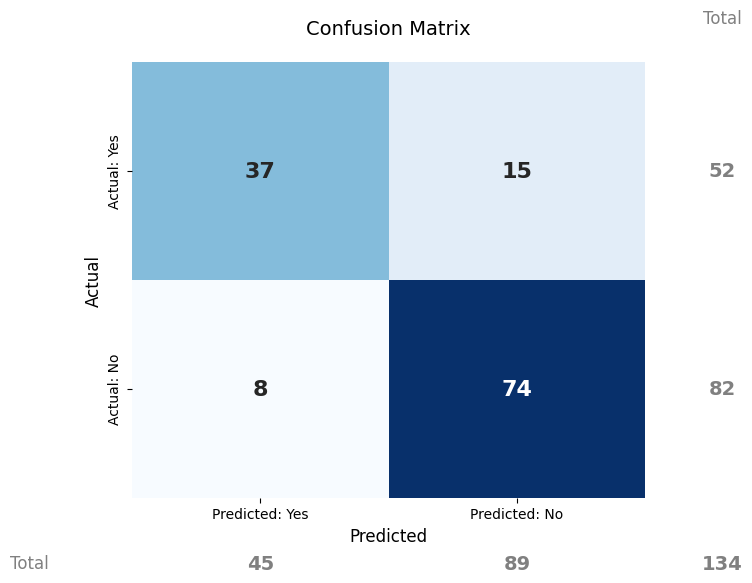

In [29]:
cm = confusion_matrix(y_valid, pred)

# Flip the matrix to match presentation order:
# Rows: Actual Yes (top), Actual No (bottom)
# Cols: Predicted Yes (left), Predicted No (right)
cm_flipped = np.array([[cm[1,1], cm[1,0]],   # Actual Yes: TP, FN
                       [cm[0,1], cm[0,0]]])   # Actual No:  FP, TN

# Calculate totals
row_totals = cm_flipped.sum(axis=1)  # [actual_yes_total, actual_no_total]
col_totals = cm_flipped.sum(axis=0)  # [pred_yes_total, pred_no_total]
grand_total = cm_flipped.sum()

# Create figure with extra space for totals
fig, ax = plt.subplots(figsize=(8, 6))

# Plot only the 2x2 heatmap (no totals in colored cells)
sns.heatmap(cm_flipped, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: Yes', 'Predicted: No'],
            yticklabels=['Actual: Yes', 'Actual: No'],
            annot_kws={'size': 16, 'weight': 'bold'},
            ax=ax)

# Add row totals on the right (outside heatmap)
for i, total in enumerate(row_totals):
    ax.text(2.3, i + 0.5, str(total), ha='center', va='center',
            fontsize=14, color='gray', weight='bold')

# Add column totals at the bottom (outside heatmap)
for j, total in enumerate(col_totals):
    ax.text(j + 0.5, 2.3, str(total), ha='center', va='center',
            fontsize=14, color='gray', weight='bold')

# Add grand total
ax.text(2.3, 2.3, str(grand_total), ha='center', va='center',
        fontsize=14, color='gray', weight='bold')

# Add "Total" labels
ax.text(2.3, -0.2, 'Total', ha='center', va='center', fontsize=12, color='gray')
ax.text(-0.4, 2.3, 'Total', ha='center', va='center', fontsize=12, color='gray')

plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()


- Top-left: True Positives (correctly predicted survivors)
- Top-right: False Negatives (survivors predicted as non-survivors)
- Bottom-left: False Positives (non-survivors predicted as survivors)
- Bottom-right: True Negatives (correctly predicted non-survivors)

# 📈 ROC Curve and AUC (Beginner Explanation)

The **ROC Curve** (Receiver Operating Characteristic) is a powerful tool for evaluating classification models.

The ROC curve plots:
- **X-axis**: False Positive Rate (FPR) - passengers predicted to survive who actually didn't
- **Y-axis**: True Positive Rate (TPR) - passengers correctly predicted to survive

**AUC** stands for **Area Under the Curve** - specifically, the area under the ROC curve.
- **AUC = 1.0**: Perfect classifier (separates classes perfectly)
- **AUC = 0.5**: Random guessing (no better than flipping a coin)
- **AUC < 0.5**: Worse than random (model is confused!)

**Key insights:**
- The closer the curve hugs the **top-left corner**, the better
- The **diagonal line** represents random guessing
- A curve **above the diagonal** means the model is useful


## 🔑 Beginner Takeaway

1. **Higher AUC = Better model** at distinguishing survivors from non-survivors
2. The ROC curve shows the **trade-off** between catching more survivors (TPR) and making more false alarms (FPR)
3. An AUC of **0.8+** is generally considered good for most applications


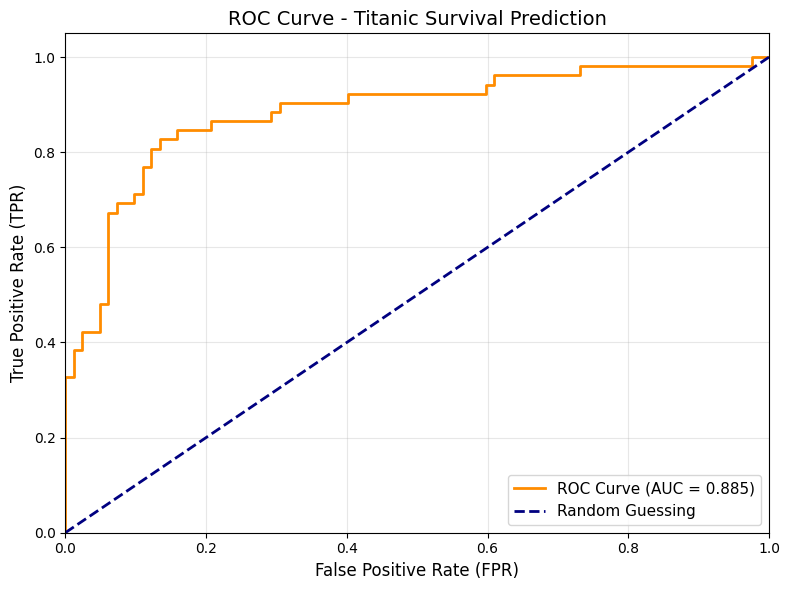


AUC Score: 0.8846
Interpretation: The model has a 88.5% chance of correctly
distinguishing between survivors and non-survivors.


In [30]:
# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_valid)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve - Titanic Survival Prediction', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nAUC Score: {roc_auc:.4f}')
print(f'Interpretation: The model has a {roc_auc*100:.1f}% chance of correctly')
print(f'distinguishing between survivors and non-survivors.')


# 🔍 SHAP Feature Importance

## What is SHAP?

**SHAP** (SHapley Additive exPlanations) is a powerful tool that helps us understand **why** our model makes the predictions it does.

SHAP tells us which features (columns) have the **most influence** on the model's predictions:

- **Higher SHAP value** = More influence on the prediction
- **Positive values** = Feature pushes prediction toward survival
- **Negative values** = Feature pushes prediction toward not surviving

## 🖼 How to Read the Chart

The bar chart below shows the **average impact** of each feature:

- Features at the **top** have the most influence
- Features at the **bottom** have the least influence
- This helps us understand what the model "learned" from the data

SHAP answers the question: **"Which features matter most for predicting survival?"**

This helps us:
1. **Trust** our model by understanding its reasoning
2. **Improve** our model by focusing on important features
3. **Explain** predictions to others in a clear way

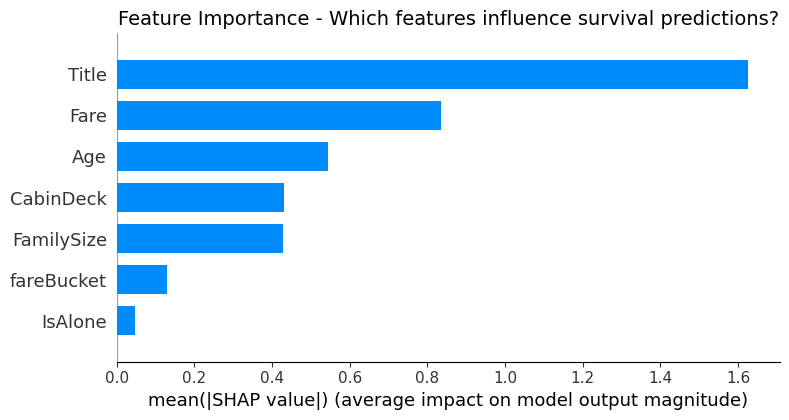


📊 Interpretation:
The features at the top of the chart have the most influence on
whether the model predicts a passenger will survive or not.


In [31]:
# Create SHAP explainer for our model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_valid)

# Plot feature importance (mean absolute SHAP values)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_valid, plot_type="bar", show=False)
plt.title('Feature Importance - Which features influence survival predictions?', fontsize=14)
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("The features at the top of the chart have the most influence on")
print("whether the model predicts a passenger will survive or not.")